In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/TS/sales.csv')
data['0'] = pd.to_datetime(data['0'])

In [19]:
# Preprocess the data to feed into LSTM
model_data = pd.DataFrame()
trends = pd.DataFrame()
seasons = pd.DataFrame()

for i in range(50):
    x = data[['0',str(i+1)]]
    x = x.set_index('0')
    res = seasonal_decompose(x , model='additive').observed
    model_data = pd.concat([model_data,res] , axis = 1)
    result = seasonal_decompose(x , model='additive')
    trend = result.trend
    trends = pd.concat([trends,trend] , axis = 1)
    season = result.seasonal
    seasons = pd.concat([seasons,season] , axis = 1)
model_data.dropna(inplace=True)


lagged_data = pd.DataFrame()
lag = 50
for i in range(lag+1):
    lagged_data = pd.concat([model_data.shift(i), lagged_data], axis=1)
lagged_data.dropna(inplace=True)
lagged_data.columns = list(range(1, lagged_data.shape[1] + 1))

X = lagged_data[list(range(1, lag * 50 + 1))]
Y = lagged_data[list(range(lag * 50 + 1, (lag + 1) * 50 + 1))]


lim = int(X.shape[0] * 0.8)
trainX = X[0:lim]
testX = X[lim:]
trainY = Y[0:lim]
testY = Y[lim:]

trainX = trainX.to_numpy()
trainY = trainY.to_numpy()
testX = testX.to_numpy()
testY = testY.to_numpy()

mean = trainX.mean(axis=0).reshape((1, -1))
std = trainX.std(axis=0).reshape((1, -1))
trainX = (trainX - mean) / std
testX = (testX - mean) / std

In [25]:
### Reshaping the input to be fed into LSTM in the form of (number of samples , number of timesteps , number of features per timesetep)

trainX = trainX.reshape((trainX.shape[0], lag, 50))
testX = testX.reshape((testX.shape[0], lag, 50))

In [59]:
#### Applying LSTM to the 50 time series and predicting the next timestep values for train and test set

y_pred_test = pd.DataFrame()
y_pred_train = pd.DataFrame()

for i in range(50):
    model = Sequential()
    model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(trainX, trainY[:, i], epochs=50, batch_size=64, validation_data=(testX, testY[:, i]), verbose=0, shuffle=False)
    pred = pd.DataFrame(model.predict(testX))
    y_pred_test = pd.concat([y_pred_test,pred], axis=1)
    pred = pd.DataFrame(model.predict(trainX))
    y_pred_train = pd.concat([y_pred_train,pred], axis=1)
    print(i+1,"th product train score", model.evaluate(trainX,trainY[:,i]) , "Test Score :",model.evaluate(testX,testY[:,i]))
    

12/12 [==============================] - 0s 2ms/step - loss: 3.5493
1 th product train score 0.474770188331604 Test Score : 3.5493171215057373
12/12 [==============================] - 0s 2ms/step - loss: 4.0645
2 th product train score 0.508639931678772 Test Score : 4.064516067504883
12/12 [==============================] - 0s 2ms/step - loss: 3.8281
3 th product train score 0.4922129511833191 Test Score : 3.828145742416382
12/12 [==============================] - 0s 2ms/step - loss: 3.9362
4 th product train score 0.4239758253097534 Test Score : 3.9361579418182373
12/12 [==============================] - 0s 2ms/step - loss: 3.2568
5 th product train score 0.35605940222740173 Test Score : 3.2568352222442627
12/12 [==============================] - 0s 2ms/step - loss: 2.9942
6 th product train score 0.4136172831058502 Test Score : 2.994175910949707
12/12 [==============================] - 0s 2ms/step - loss: 3.1020
7 th product train score 0.3610857129096985 Test Score : 3.1020095348358

In [60]:
### Evaluating MAE for train and test set

from sklearn.metrics import mean_squared_error, mean_absolute_error
mae_test = 0 
mae_train = 0
for i in range(50):
  mae_test = mae_test+ mean_absolute_error(testY[:, i], y_pred_test.iloc[:,i])
  mae_train = mae_train+ mean_absolute_error(trainY[:, i], y_pred_train.iloc[:,i])
print("Test MAE:",mae_test/50," , Train MAE",mae_train/50 )

Test MAE: 4.393311132835185  , Train MAE 0.5390612111254138


# Experimentation code for individual time series 

In [26]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY[:, 21], epochs=100, batch_size=64, validation_data=(testX, testY[:, 21]), verbose=0, shuffle=False)

In [27]:
y_pred_test = model.predict(testX)
y_pred_train = model.predict(trainX)

(0.0, 90.0)

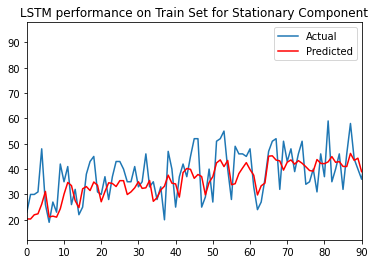

In [28]:
plt.figure()
plt.title("LSTM performance on Train Set for Stationary Component")
plt.plot(np.array(trainY)[:, 21] , label = "Actual") 
plt.plot(np.array(y_pred_train) , color ='red' , label="Predicted")
plt.legend()
plt.xlim([0,90])


(0.0, 90.0)

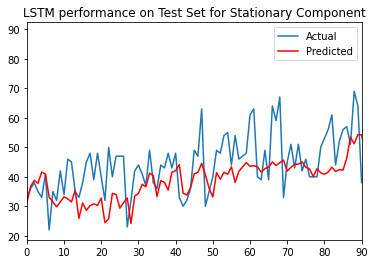

In [29]:
plt.figure()
plt.title("LSTM performance on Test Set for Stationary Component")
plt.plot(np.array(testY)[:, 21] , label = "Actual") 
plt.plot(np.array(y_pred_test) , color ='red',label="Predicted")
plt.legend()
plt.xlim([0,90])

In [30]:
mae = mean_absolute_error(testY[:, 21], y_pred_test)
print("Test MAE:",mae)
mae = mean_absolute_error(trainY[:, 21], y_pred_train)
print("Train MAE:",mae)

Test MAE: 7.186176691162452
Train MAE: 5.483957219459641


In [63]:
trainXdf = X[0:lim]
testXdf = X[lim:]

trainYdf = Y[0:lim]
testYdf = Y[lim:]

true = pd.DataFrame(testYdf.iloc[:,21])
t = pd.DataFrame(trends.iloc[:,21])
s =pd.DataFrame(seasons.iloc[:,21])
true = true.join(t)
true.columns = list(range(2))
true = true.join(s)
true.columns = list(["Resid","Trend" ,"Seasonal"])
true


,Resid,Trend,Seasonal
0,,,
2016-12-30,6.888462,38.857143,3.254396
2016-12-31,11.993956,38.571429,6.434615
2017-01-01,-5.033516,39.285714,8.747802
2017-01-02,-4.600000,39.571429,-9.971429
2017-01-03,-6.045604,37.285714,-4.240110
...,...,...,...
2017-12-24,-8.604945,41.857143,8.747802
2017-12-25,-3.171429,40.142857,-9.971429
2017-12-26,12.954396,39.285714,-4.240110


In [64]:
predicted = y_pred_test.iloc[:,0].values + true.iloc[:,1].values + true.iloc[:,2].values
actual = true.iloc[:,0]+true.iloc[:,1]+true.iloc[:,2]

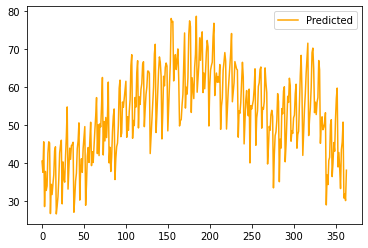

In [65]:
plt.plot(predicted , label = "Predicted",color ="orange" , )
plt.legend()


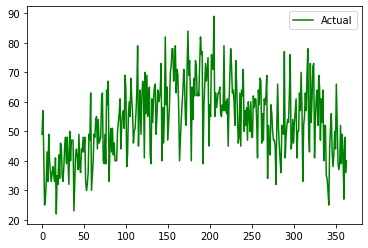

In [66]:
plt.figure()
plt.plot(actual.values, label = "Actual" ,color = "green")
plt.legend()
plt.show()